# Hotele na wakacje

## Wstępna ocena przydatności danych

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import CategoricalNB
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.ensemble import RandomForestClassifier

sns.set()

In [4]:
df = pd.read_csv('hotels.csv', index_col='id')

In [5]:
df.describe()

,latitude,longitude,ranking,ranking_out_of,rating,num_reviews,photo_count,amenities_count,awards_count
count,1165.000000,1165.000000,1165.00000,1165.000000,1165.000000,1165.000000,1165.000000,1165.000000,1165.000000
mean,31.607489,35.995338,147.04206,597.191416,4.337339,1929.244635,1560.814592,68.399142,0.842060
std,6.851927,19.677281,155.82979,372.791391,0.508456,2405.844558,2328.728259,40.316077,0.949289
min,24.816820,2.070631,1.00000,1.000000,2.500000,1.000000,0.000000,0.000000,0.000000
25%,25.220015,27.138655,24.00000,218.000000,4.000000,219.000000,168.000000,40.000000,0.000000
50%,27.907465,34.327927,81.00000,553.000000,4.500000,1073.000000,596.000000,61.000000,1.000000
75%,38.424140,55.266380,242.00000,982.000000,4.500000,2607.000000,1857.000000,96.000000,2.000000
max,41.435448,55.662610,697.00000,1202.000000,5.000000,15221.000000,13798.000000,208.000000,4.000000


In [6]:
df.select_dtypes(exclude=["number"]).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1165 entries, 1006161 to 9865057
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         1165 non-null   object
 1   city         1165 non-null   object
 2   region       1165 non-null   object
 3   country      1165 non-null   object
 4   brand        487 non-null    object
 5   price_level  1165 non-null   object
dtypes: object(6)
memory usage: 63.7+ KB


## Przygotowanie danych

In [7]:
df.price_level.value_counts()

$$      544
$       301
$$$     174
$$$$    146
Name: price_level, dtype: int64

In [8]:
str(round(len(df.loc[df.price_level == '$$']) / len(df), 4) * 100) + '%'

'46.7%'

In [9]:
df['price_level_num'] = df.price_level.apply(len)

<Axes: xlabel='price_level_num', ylabel='Count'>

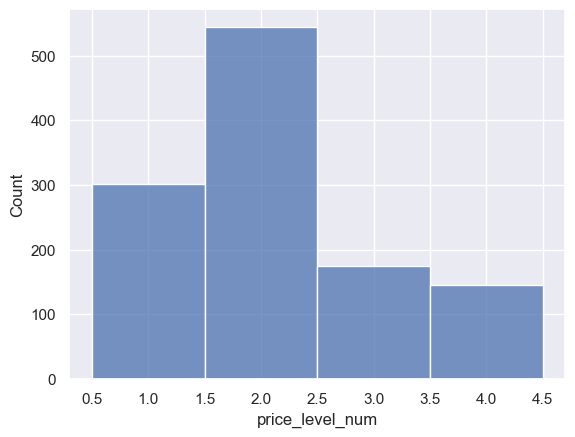

In [10]:
sns.histplot(data=df, x="price_level_num", discrete=True)

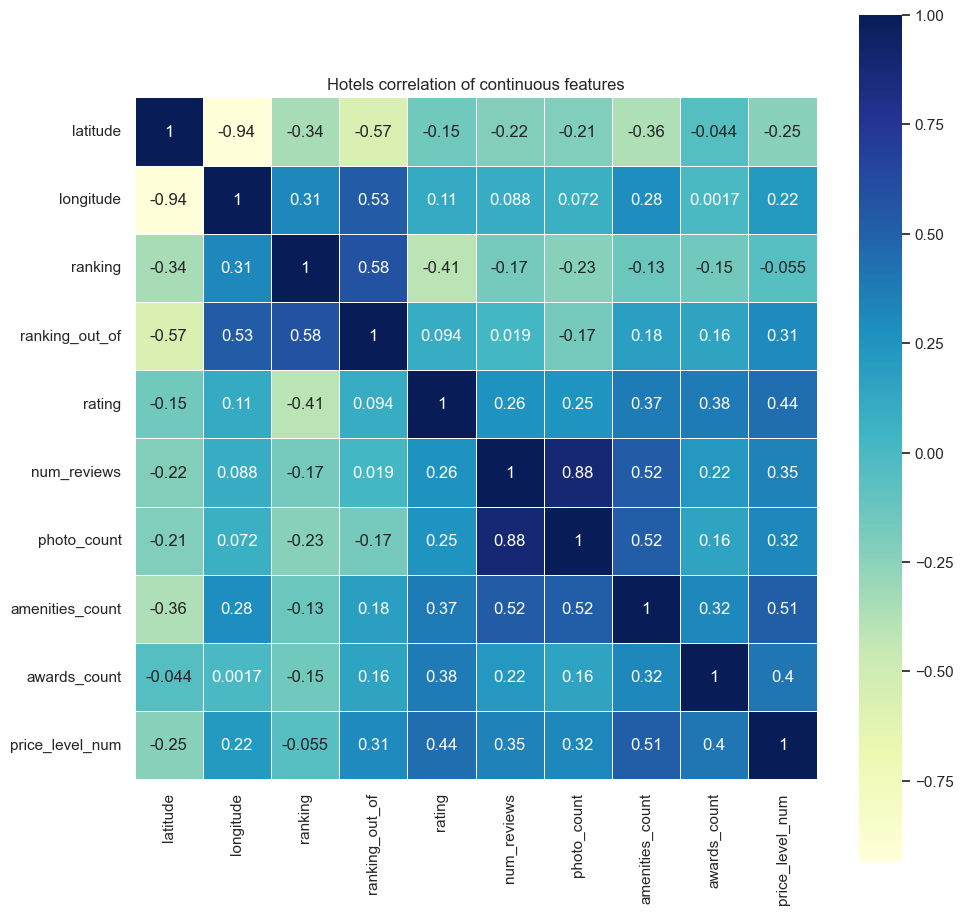

In [11]:
plt.subplots(figsize=(11, 11))
plt.title('Hotels correlation of continuous features')
ax = sns.heatmap(df.select_dtypes(include='number').corr(), 
                 annot=True, 
                 linewidths=.5, 
                 cmap="YlGnBu",
                 square=True
                );

`ranking` ma najmniejszą korelację

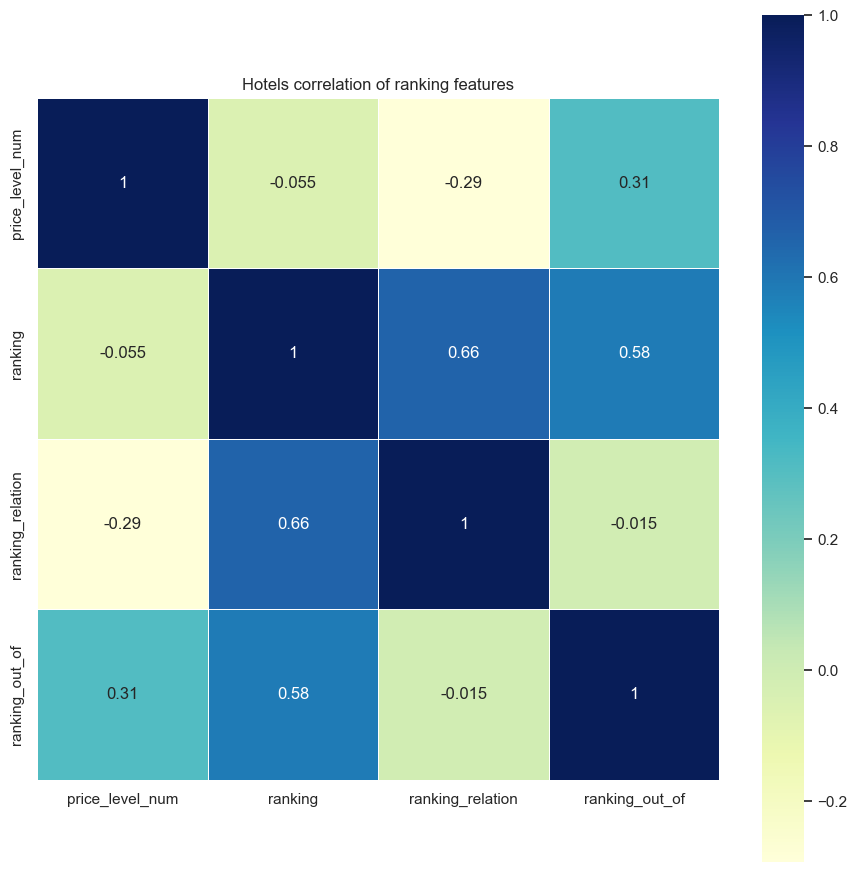

In [12]:
plt.subplots(figsize=(11, 11))
plt.title('Hotels correlation of ranking features')
df['ranking_relation'] = round(df.ranking / df.ranking_out_of, 2)
ax = sns.heatmap(df[['price_level_num', 'ranking', 'ranking_relation', 'ranking_out_of']].corr(), 
                 annot=True, 
                 linewidths=.5, 
                 cmap="YlGnBu",
                 square=True
                );


`ranking_relation` ma lepszą korelację za `ranking`

In [13]:
# dropped Y's low correlation ranking and name
X = df.drop(['price_level', 'price_level_num', 'ranking', 'name', 'city'], axis= 'columns')
X = pd.get_dummies(X)
X_scaled = minmax_scale(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df.price_level_num, test_size=0.2, random_state=1)
X_train_split, X_validation, y_train_split, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
X_train.shape, X_train_split.shape, X_validation.shape, X_test.shape

((932, 188), (745, 188), (187, 188), (233, 188))

## Modelowanie

In [14]:
df.price_level_num.value_counts(normalize=True)

2    0.466953
1    0.258369
3    0.149356
4    0.125322
Name: price_level_num, dtype: float64

Algorytm naiwny zawsze wybierając 2 będzie miał 47% dokładności

In [15]:
knn = KNeighborsClassifier()
param_grid = {"n_neighbors": np.arange(1, 20)}
knn_gscv = GridSearchCV(knn, param_grid, cv=10)
knn_gscv.fit(X_train, y_train)
knn_gscv.best_params_, knn_gscv.best_score_

({'n_neighbors': 6}, 0.6125829329672845)

In [16]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train_split, y_train_split)
y_pred = knn.predict(X_validation)
confusion_matrix(y_validation, y_pred)

array([[38, 14,  1,  0],
       [18, 73,  0,  0],
       [ 1, 12,  3,  0],
       [ 2, 15,  8,  2]], dtype=int64)

In [17]:
print(classification_report(y_validation, y_pred))

              precision    recall  f1-score   support

           1       0.64      0.72      0.68        53
           2       0.64      0.80      0.71        91
           3       0.25      0.19      0.21        16
           4       1.00      0.07      0.14        27

    accuracy                           0.62       187
   macro avg       0.63      0.45      0.44       187
weighted avg       0.66      0.62      0.58       187



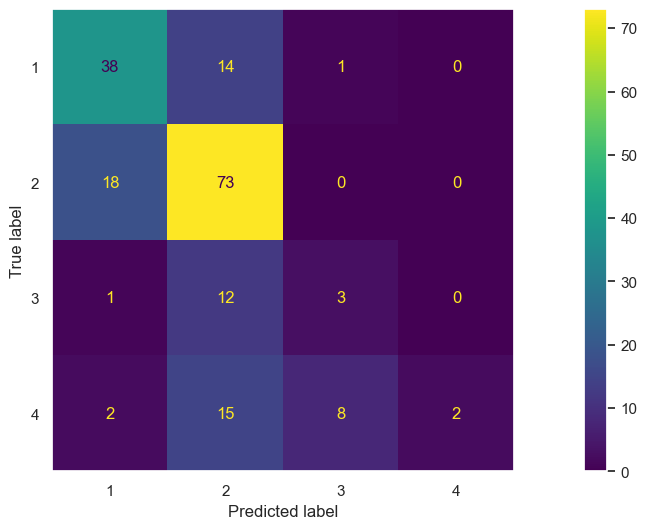

In [18]:
c_matrix = confusion_matrix(y_validation, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = c_matrix, display_labels=sorted(list(set(y_test))))
fig, ax = plt.subplots(figsize=(18, 6))
ax.grid(False)
cm_display.plot(ax=ax)
plt.show()

In [19]:
clf = LogisticRegression(solver='sag').fit(X_train, y_train)
cross_scores = cross_val_score(clf, X_train, y_train, cv=10)

print(cross_scores)
cross_scores.mean()

[0.70212766 0.53191489 0.67741935 0.59139785 0.60215054 0.56989247
 0.67741935 0.6344086  0.61290323 0.56989247]


0.6169526424159232

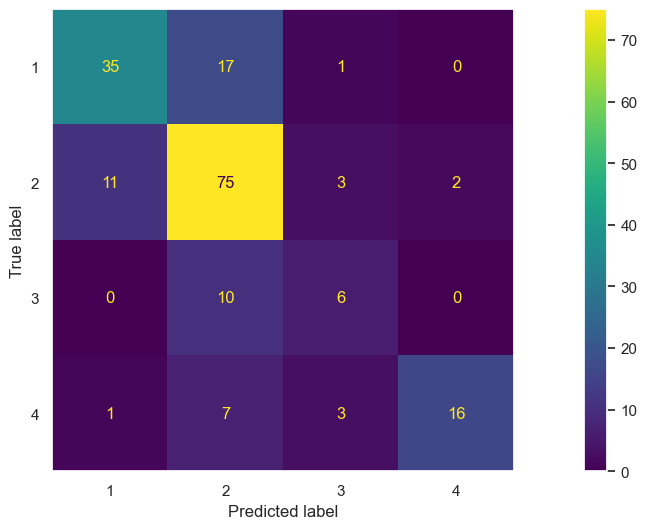

In [20]:
y_pred = clf.predict(X_validation)
clf.score(X_validation, y_validation)
c_matrix = confusion_matrix(y_validation, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = c_matrix, display_labels=sorted(list(set(y_test))))
fig, ax = plt.subplots(figsize=(18, 6))
ax.grid(False)
cm_display.plot(ax=ax)
plt.show()

In [21]:
X_df = df.drop(['price_level', 'price_level_num', 'ranking', 'name', 'city'], axis= 'columns')
enc = OrdinalEncoder()
X_df.brand.fillna('no brand', inplace=True)
X = enc.fit_transform(X_df)
# X_scaled = minmax_scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, df.price_level_num, test_size=0.2, random_state=1)
X_train_split, X_validation, y_train_split, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
X_train.shape, X_validation.shape, X_test.shape

((932, 12), (187, 12), (233, 12))

In [22]:
X_df.nunique()

region                 6
country                5
latitude            1148
longitude           1153
ranking_out_of        49
rating                 6
num_reviews          929
photo_count          877
amenities_count      173
brand                169
awards_count           5
ranking_relation      83
dtype: int64

In [23]:
clf = CategoricalNB(min_categories=X_df.nunique())
cross_scores = cross_val_score(clf, X_train, y_train, cv=10)
print(cross_scores)
cross_scores.mean()

[0.62765957 0.54255319 0.58064516 0.58064516 0.52688172 0.58064516
 0.58064516 0.52688172 0.52688172 0.52688172]


0.5600320292839168

              precision    recall  f1-score   support

           1       0.58      0.62      0.60        53
           2       0.64      0.60      0.62        91
           3       0.28      0.56      0.38        16
           4       0.58      0.26      0.36        27

    accuracy                           0.56       187
   macro avg       0.52      0.51      0.49       187
weighted avg       0.58      0.56      0.56       187



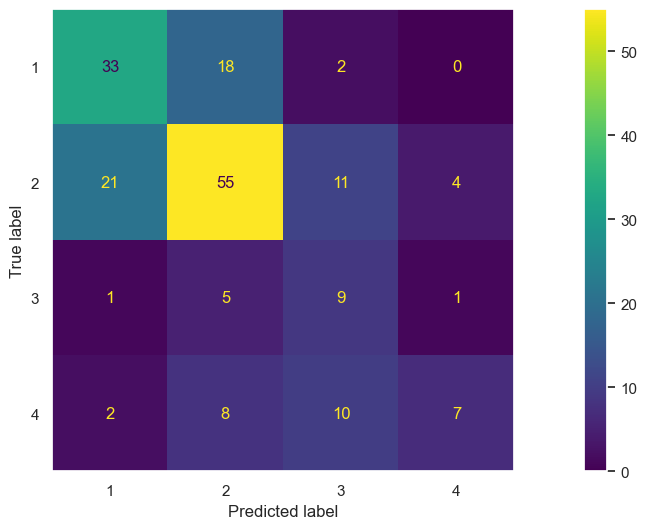

In [24]:
clf.fit(X_train_split, y_train_split)
y_pred = clf.predict(X_validation)
print(classification_report(y_validation, y_pred))
c_matrix = confusion_matrix(y_validation, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = c_matrix, display_labels=sorted(list(set(y_test))))
fig, ax = plt.subplots(figsize=(18, 6))
ax.grid(False)
cm_display.plot(ax=ax)
plt.show()

In [25]:
# dropped Y's low correlation ranking and name
X = df.drop(['price_level', 'price_level_num', 'ranking', 'name', 'city'], axis= 'columns')
X = pd.get_dummies(X)
X_scaled = minmax_scale(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df.price_level_num, test_size=0.2, random_state=1)
X_train_split, X_validation, y_train_split, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [26]:
lda = LDA(store_covariance=True)
cross_scores = cross_val_score(lda, X_train, y_train, cv=10)
print(cross_scores)
cross_scores.mean()

[0.74468085 0.53191489 0.62365591 0.60215054 0.56989247 0.64516129
 0.64516129 0.58064516 0.62365591 0.59139785]


0.615831617478838

In [27]:
lda.fit(X_train_split, y_train_split)
lda_pred = lda.predict(X_validation)
print(classification_report(y_validation, lda_pred))

              precision    recall  f1-score   support

           1       0.67      0.58      0.63        53
           2       0.57      0.73      0.64        91
           3       0.27      0.19      0.22        16
           4       0.40      0.22      0.29        27

    accuracy                           0.57       187
   macro avg       0.48      0.43      0.44       187
weighted avg       0.55      0.57      0.55       187



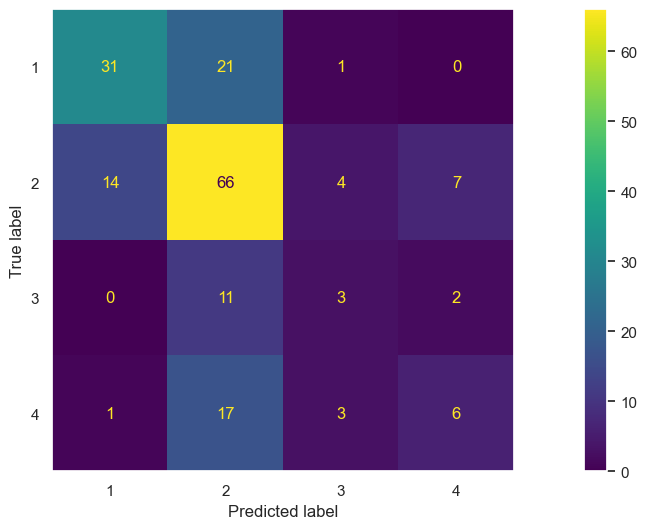

In [28]:
c_matrix = confusion_matrix(y_validation, lda_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = c_matrix, display_labels=sorted(list(set(y_test))))
fig, ax = plt.subplots(figsize=(18, 6))
ax.grid(False)
cm_display.plot(ax=ax)
plt.show()

In [29]:
qda = QDA(store_covariance=True)
cross_scores = cross_val_score(qda, X_train, y_train, cv=10)
print(cross_scores)
cross_scores.mean()

c:\Users\marko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\marko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\marko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\marko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\marko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\marko\AppData\Local\Programs\Python\

[0.36170213 0.37234043 0.41935484 0.34408602 0.3655914  0.3655914
 0.43010753 0.3655914  0.35483871 0.33333333]


c:\Users\marko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


0.37125371768474036

c:\Users\marko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


              precision    recall  f1-score   support

           1       0.67      0.58      0.63        53
           2       0.57      0.73      0.64        91
           3       0.27      0.19      0.22        16
           4       0.40      0.22      0.29        27

    accuracy                           0.57       187
   macro avg       0.48      0.43      0.44       187
weighted avg       0.55      0.57      0.55       187



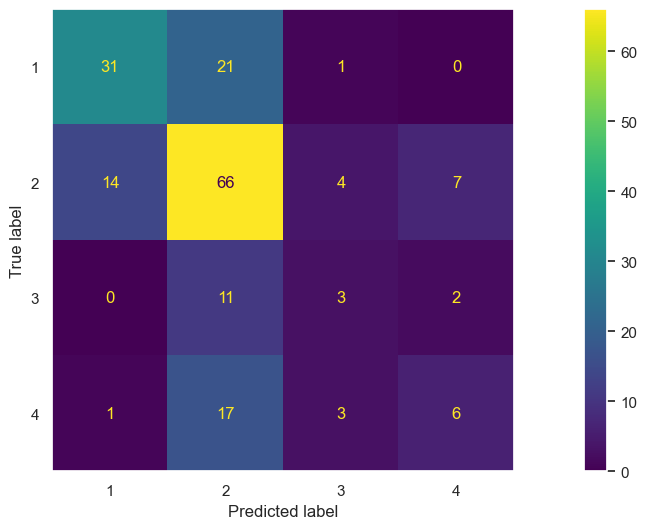

In [30]:
qda.fit(X_train_split, y_train_split)
qda_pred = lda.predict(X_validation)
print(classification_report(y_validation, lda_pred))
c_matrix = confusion_matrix(y_validation, qda_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = c_matrix, display_labels=sorted(list(set(y_test))))
fig, ax = plt.subplots(figsize=(18, 6))
ax.grid(False)
cm_display.plot(ax=ax)
plt.show()

LDA KNN, LogisticRegression są najlepsze z próbowanych modeli

In [43]:
lda.fit(X_train, y_train)
lda_pred = lda.predict(X_test)
print(classification_report(y_test, lda_pred))

              precision    recall  f1-score   support

           1       0.71      0.65      0.68        57
           2       0.62      0.77      0.69       112
           3       0.29      0.22      0.25        32
           4       0.83      0.47      0.60        32

    accuracy                           0.62       233
   macro avg       0.61      0.53      0.55       233
weighted avg       0.63      0.62      0.61       233



In [39]:
rfc=RandomForestClassifier(random_state=0)

param_grid = { 
    'n_estimators': [50, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [5,6,8,10],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 8, 10],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 300]})

In [40]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'n_estimators': 50}

In [42]:
CV_rfc.best_score_

0.6448277844862285

In [44]:
rfc_pred = CV_rfc.best_estimator_.predict(X_test)
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           1       0.74      0.56      0.64        57
           2       0.60      0.90      0.72       112
           3       0.38      0.09      0.15        32
           4       0.87      0.41      0.55        32

    accuracy                           0.64       233
   macro avg       0.65      0.49      0.52       233
weighted avg       0.64      0.64      0.60       233



Najlepszym klasyfikatorem został Random Forest Classifier